In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import pickle
import glob
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout,Convolution2D,MaxPooling2D,Flatten,Lambda
from keras.optimizers import Adam
from keras.models import model_from_json
import json

Using TensorFlow backend.


## Load Dataset

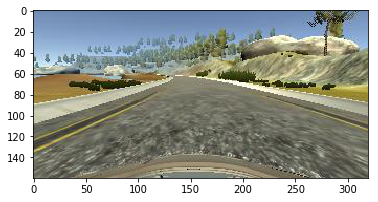

0.0


In [2]:
import random as rand

img_dir = '/Users/eren/Desktop/Dataset2/IMG/'
data_csv_dir = '/Users/eren/Desktop/Dataset2/'
data_csv_name = 'driving_log.csv'

col_names = ['center', 'left','right','steering','throttle','brake','speed']

training_data = pd.read_csv(data_csv_dir + data_csv_name, names = col_names)
training_data.head()

numSample = training_data.shape[0]

imgLocation = training_data['center'][49]
steer = training_data['steering'][49]
img = mpimg.imread(imgLocation)

plt.imshow(img)
plt.show()
print(steer)

## Data Visualization

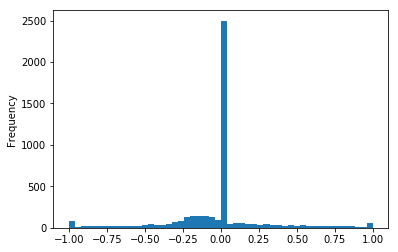

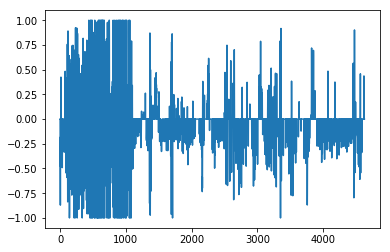

In [3]:
training_data['steering'].plot.hist(bins=50)
plt.show()

plt.plot(training_data['steering'])
plt.show()

## Filter Useless Repeated Data Out

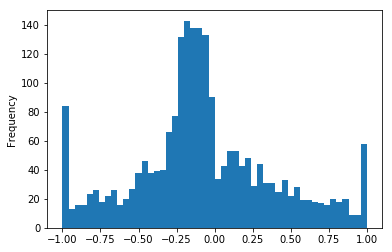

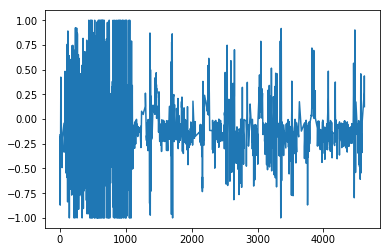

(2165, 7)


In [4]:
from collections import deque

def filter_driving_straight(data_df, hist_items=6):
    steering_history = deque([])
    
    drop_rows=[]
    
    for idx, row in data_df.iterrows():
        # controls = [getattr(row, control) for control in vehicle_controls]
        steering = getattr(row, 'steering')
        
        # record the recent steering history
        steering_history.append(steering)
        if len(steering_history) > hist_items:
            steering_history.popleft()

        # if just driving in a straight line continue
        if steering_history.count(0.0) == hist_items:
            drop_rows.append(idx)

    return data_df.drop(data_df.index[drop_rows])

training_data2 = filter_driving_straight(training_data, 1)

training_data2['steering'].plot.hist(bins=50)
plt.show()

plt.plot(training_data2['steering'])
plt.show()

print(training_data2.shape)

## Dataset Pre-processing Definitions

In [5]:
import random as rand

def affine_trans(img, steer):
    
    h, w = img.shape
    
    rot = 1
    scale = 0.02
    
    Mrot = cv2.getRotationMatrix2D((h / 2, w / 2), rand.uniform(- rot, rot), rand.uniform(1 - scale, 1 + scale))
    
    pts1 = np.float32([[0, 0], [w, 0], [w, h]])
    a = 0
    shift = 10
    
    shiftx = rand.randint(- shift, shift)
    shifty = rand.randint(- shift / 2, shift / 2)
    
    pts2 = np.float32([[
        0 + rand.randint (- a, a) + shiftx,
        0 + rand.randint (- a, a) + shifty,
    ],[
        w + rand.randint (- a, a) + shiftx,
        0 + rand.randint (- a, a) + shifty,
    ],[
        w + rand.randint (- a, a) + shiftx,
        h + rand.randint (- a, a) + shifty,
    ]])
    
    M = cv2.getAffineTransform(pts1, pts2)
    
    augmented_img = cv2.warpAffine(cv2.warpAffine(img, Mrot, (w, h)), M, (w, h))
    augmented_steer = shiftx * 0.00625 + steer
    
    return augmented_img, augmented_steer

def augment_brightness(img):
    img = img.astype(np.uint8)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    img_hsv[:,:,2] = img_hsv[:,:,2] * (np.random.uniform() + 0.25)
    img_aug = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    return img_aug

def flip_imgs(img, centerSteer):

    steerf = np.zeros((1, 1))
            
    for i in range(len(centerSteer)):
        if i%100 == 0:
            print(i)
        if centerSteer[i] < 0:

            imgf = cv2.flip(img[i], 1)
            steerf = -1 * centerSteer[i]
            
            imgf = imgf.reshape(1, imgf.shape[0], imgf.shape[1])
            img = np.append(img, imgf, axis = 0)
            centerSteer = np.append(centerSteer, steerf)
            
    return img, centerSteer

def load_imgs(imgLoc, trainFlag):
    if trainFlag:
        imgLocation = str(np.char.strip(imgLoc))
        img = mpimg.imread(imgLocation)
        lenx = img.shape[0]
        leny = img.shape[1]
        img = cv2.resize(img, (int(leny/2), int(lenx/2)))
        
        img_hsv = augment_brightness(img)
        img_gray = cv2.cvtColor(img_hsv, cv2.COLOR_RGB2GRAY)
        
    return img_gray

def cam_adjust(steer, Left = True):
    if Left == True:
        steer = steer - 0.25
    else:
        steer = steer + 0.25
    return steer

## Read Dataset

In [6]:
numSample = training_data2.shape[0]

#numSample = 10
centerSteering = np.array(training_data2['steering'][0:numSample])
centerImgs = np.array([load_imgs(imgLoc, True) for imgLoc in training_data2['center'][0:numSample]], dtype = np.float32)

numSample_left = training_data2.shape[0]
leftSteering = np.array(training_data2['steering'][0:numSample_left])
leftImgs = np.array([load_imgs(imgLoc, True) for imgLoc in training_data2['left'][0:numSample_left]], dtype = np.float32)

numSample_right = training_data2.shape[0]
rightSteering = np.array(training_data2['steering'][0:numSample_right])
rightImgs = np.array([load_imgs(imgLoc, True) for imgLoc in training_data2['right'][0:numSample_right]], dtype = np.float32)

leftSteering = cam_adjust(leftSteering, True)
rightSteering = cam_adjust(rightSteering, False)

centerImgs = np.append(centerImgs, leftImgs)
centerImgs = centerImgs.reshape(numSample * 2, 80, 160)

centerImgs = np.append(centerImgs, rightImgs)
centerImgs = centerImgs.reshape(numSample * 3, 80, 160)

centerSteering = np.append(centerSteering, leftSteering)
centerSteering = centerSteering.reshape(2 * numSample, 1)

centerSteering = np.append(centerSteering, rightSteering)
centerSteering = centerSteering.reshape(3 * numSample, 1)

numSample = centerImgs.shape[0]

print(centerImgs.shape)
print(centerSteering.shape)

(6495, 80, 160)
(6495, 1)


affine transform...
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
done.
image flipping...
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500

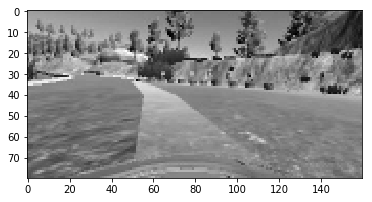

-0.51579


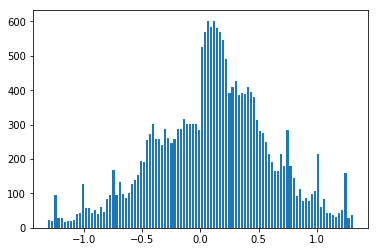

In [7]:
idx = 1

#plt.imshow(centerImgs[idx], cmap = 'gray')
#plt.show()

##### Affine Transform ####
print('affine transform...')
cimg = np.zeros((numSample, 80, 160))
csteer = np.zeros((numSample, 1))
for i in range(numSample):
    if i%100 == 0:
        print(i)
    cimg[i], csteer[i] = affine_trans(centerImgs[i], centerSteering[i])
    
centerImgs = np.append(centerImgs, cimg)
centerImgs = centerImgs.reshape(2 * numSample, 80, 160)

centerSteering = np.append(centerSteering, csteer)
centerSteering = centerSteering.reshape(2 * numSample, 1)
print('done.')
##########################

##### Image Flipping ####
print('image flipping...')
centerImgs, centerSteering = flip_imgs(centerImgs, centerSteering)
print('done.')
#########################

print(centerImgs.shape)
print(centerSteering.shape)

plt.imshow(centerImgs[idx], cmap = 'gray')
plt.show()

centerImgs = centerImgs.reshape(centerImgs.shape[0], centerImgs.shape[1], centerImgs.shape[2], 1)

print(centerSteering[idx])

hist, bins = np.histogram(centerSteering, bins=100)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

In [8]:
f_i = open('centerImgs3.p', 'wb')
pickle.dump(centerImgs, f_i, pickle.HIGHEST_PROTOCOL)
f_i.close()

f_s = open('centerSteering3.p', 'wb')
pickle.dump(centerSteering, f_s, pickle.HIGHEST_PROTOCOL)
f_s.close()